In [1]:
import mne
import os 
import sys
from matplotlib import pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline    import Pipeline
from sklearn.model_selection import train_test_split
import pickle


BASE_DIR = r'C:\Users\adoni\Documents\CurrentStudy'
sys.path.append(rf'{BASE_DIR}\src')

from preprocessing import preprocess_raw

In [2]:
DATA_DIR = os.path.join(BASE_DIR, 'data', 'eeg')
SUBJECTS = ['002','003','005','006', '007', '008', '010','011','012']
CHANNELS = ['F7','F3','Fz','F4','F8','C3','Cz','C4','P7','P3','Pz','P4','P8']

all_epochs = []
files_name = []
for i, sub in enumerate(SUBJECTS):
    print(f'Processing subject {sub} ({i+1}/{len(SUBJECTS)})')
    clean_dir = os.path.join(DATA_DIR, f'sub-{sub}', 'raw', 'ica-clean-annot')
    if os.path.exists(clean_dir):
        for file_name in os.listdir(clean_dir):
            if file_name.endswith('.fif'):
                fname = os.path.join(clean_dir, file_name)
                files_name.append(file_name)
                raw = mne.io.read_raw_fif(fname, preload=True, verbose=False).pick(CHANNELS, verbose=False)
                preprocess_raw(raw, h_freq=48, interpolate_bads=True)
                raw.resample(250, npad='auto', verbose=False)  # Resample to 250 Hz
                raw.del_proj()  # Drop any existing projections                #raw.interpolate_bads(reset_bads=True, verbose=False)
                event_id = {'WC': 1, 'WI': 2}  # Definir los códigos de eventos esperados
                try:
                    events, _ = mne.events_from_annotations(raw, event_id=event_id, verbose=False)
                except Exception as e:
                    print(f"Error processing {file_name}: {e}")
                    continue
                try:
                    epochs = mne.Epochs(raw, events, event_id=event_id, tmin=-0.1, tmax=.8, 
                                        preload=True, verbose=False, reject={'eeg': 100e-6})
                    all_epochs.append(epochs)
                except Exception as e:
                    print(f"Error creating epochs for {file_name}: {e}")

Processing subject 002 (1/9)
Processing subject 003 (2/9)
Processing subject 005 (3/9)
Processing subject 006 (4/9)
Error processing sub-006_task-stroop_run-003_raw.fif: Could not find any of the events you specified.
Processing subject 007 (5/9)
Processing subject 008 (6/9)
Processing subject 010 (7/9)


C:\Users\adoni\Documents\CurrentStudy\src\preprocessing.py:33: RuntimeWarning: filter_length (8449) is longer than the signal (8446), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=l_freq,
C:\Users\adoni\Documents\CurrentStudy\src\preprocessing.py:33: RuntimeWarning: filter_length (8449) is longer than the signal (8045), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=l_freq,


Processing subject 011 (8/9)
Processing subject 012 (9/9)


C:\Users\adoni\Documents\CurrentStudy\src\preprocessing.py:33: RuntimeWarning: filter_length (8449) is longer than the signal (8425), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=l_freq,


In [3]:
epochs_concat = mne.concatenate_epochs(all_epochs, verbose=False)
epochs_cong = epochs_concat['WC']
epochs_incong = epochs_concat['WI']

C:\Users\adoni\AppData\Local\Temp\ipykernel_38304\4058522840.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs_concat = mne.concatenate_epochs(all_epochs, verbose=False)


In [4]:

evks_cong = []
evks_incong = []
for epochs in all_epochs:
    epochs.apply_baseline(baseline=(-0.1, 0), verbose=False)  # Eliminar desplazamiento antes del estímulo
    evoked_cong = epochs['WC'].average()
    evks_cong.append(evoked_cong)
    evoked_incong = epochs['WI'].average()
    evks_incong.append(evoked_incong)

In [5]:
FRONTO_CENTRAL = ['F7','F3','Fz','F4','F8','C3','Cz','C4']

## Grand average and compare evokeds

Identifying common channels ...
Identifying common channels ...
More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"


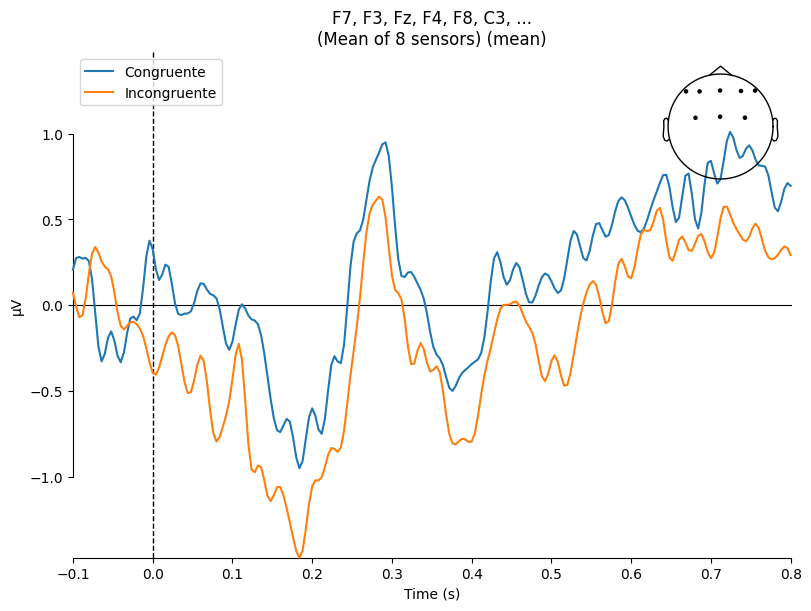

[<Figure size 800x600 with 2 Axes>]

In [6]:
from mne import grand_average

avg_cong = grand_average(evks_cong)
avg_incong = grand_average(evks_incong)

mne.viz.plot_compare_evokeds({'Congruente': avg_cong, 'Incongruente': avg_incong}, 
                             ci=True, 
                             picks=FRONTO_CENTRAL,
                             combine='mean',
                             split_legend=True,
                             show_sensors=True)


More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"


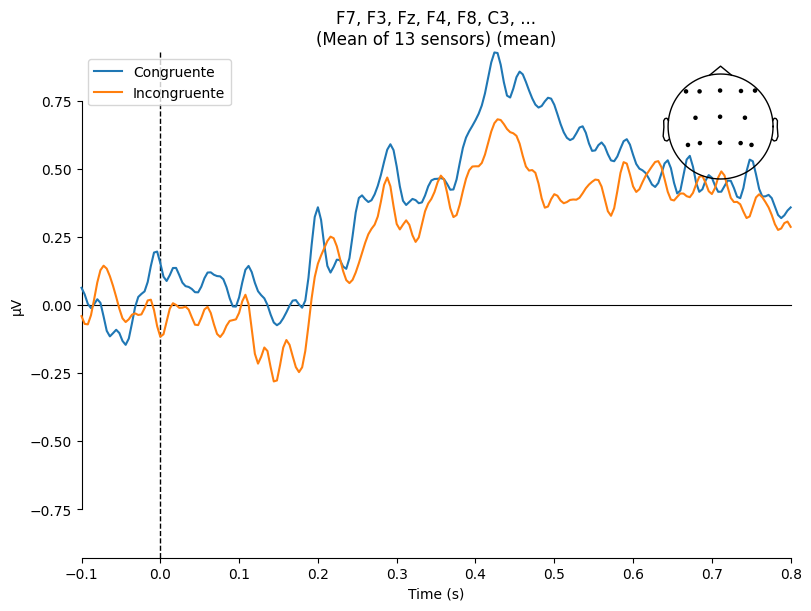

[<Figure size 800x600 with 2 Axes>]

In [7]:
mne.viz.plot_compare_evokeds({'Congruente': avg_cong, 'Incongruente': avg_incong}, 
                             ci=True, 
                             picks=CHANNELS,
                             combine='mean',
                             split_legend=True,
                             show_sensors=True)

In [58]:
CHANNELS

['F7', 'F3', 'Fz', 'F4', 'F8', 'C3', 'Cz', 'C4', 'P7', 'P3', 'Pz', 'P4', 'P8']

combining channels using "mean"
combining channels using "mean"


C:\Users\adoni\AppData\Local\Temp\ipykernel_38696\1302102659.py:10: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  plot_compare_evokeds(


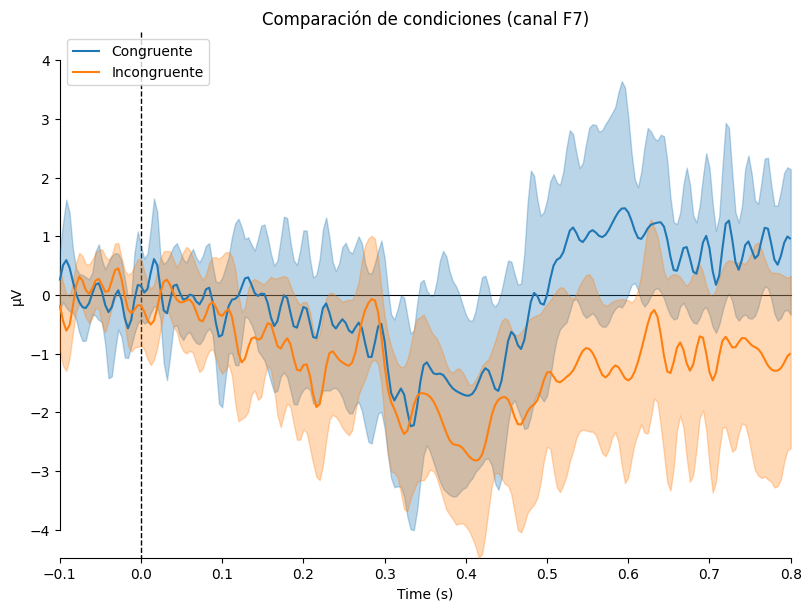

[<Figure size 800x600 with 1 Axes>]

In [217]:
#F7: 5
#P8: 5
#Cz: 4
#C4: 2
#P7: 2
#C3: 1

from mne.viz import plot_compare_evokeds
ch = 'F7'  # Canal a comparar
plot_compare_evokeds(
    {
        'Congruente': evks_cong,
        'Incongruente': evks_incong
    },
    picks=ch,
    ci=True,
    combine='mean',
    linestyles={'Congruente': '-', 'Incongruente': '-'},
    title=f'Comparación de condiciones (canal {ch})',
    #vlines=[.25, .45],
    show_sensors=False
)


In [126]:
import joblib
model_path = r'C:\Users\adoni\Documents\CurrentStudy\analysis\stroop\models\Relative_Band_Power_best_randomforest.joblib'
model = joblib.load(model_path)

In [127]:
clf = model.named_steps['clf']

In [128]:
# get importances
importances = clf.feature_importances_

In [129]:
# Define feature mapping function
def map_feature_indices():
    """Crea un mapeo de índices de características a su descripción significativa."""
    feature_names = []
    band_names = ['delta', 'theta', 'alpha', 'beta', 'gamma']

    for band in band_names:
        for ch in CHANNELS:
            feature_names.append(f"Rel_power_{band}_{ch}")
    
    return feature_names

# Define feature mapping function
feature_names = map_feature_indices()

In [195]:
# percentege of variance explained by the top 50 features above all
top_n = 40
top_indices = np.argsort(importances)[-top_n:]
# calculate the percentage of variance explained by the top 50 features
np.sum(importances[top_indices]) * 100

78.01180343887965

In [196]:
# extract how many times the channels Fz, F3 and F4 appears in the 40 top features
def count_channel_in_top_features(channel, top_n=40):
    """Cuenta cuántas veces aparece un canal específico en las características más importantes."""
    count = 0
    for i in np.argsort(importances)[-top_n:]:
        if channel in feature_names[i]:
            count += 1
    return count

# Count occurrences of channels in top features
channel_counts = {ch: count_channel_in_top_features(ch) for ch in CHANNELS}
# Ordenar y mostrar los canales más frecuentes en el top N
sorted_counts = sorted(channel_counts.items(), key=lambda x: x[1], reverse=True)
for ch, count in sorted_counts:
    print(f"{ch}: {count}")

F7: 5
Cz: 5
P7: 5
P3: 5
P8: 5
Fz: 4
C4: 3
P4: 3
C3: 2
F3: 1
F8: 1
Pz: 1
F4: 0


### Plot joint

No projector specified for this dataset. Please consider the method self.add_proj.


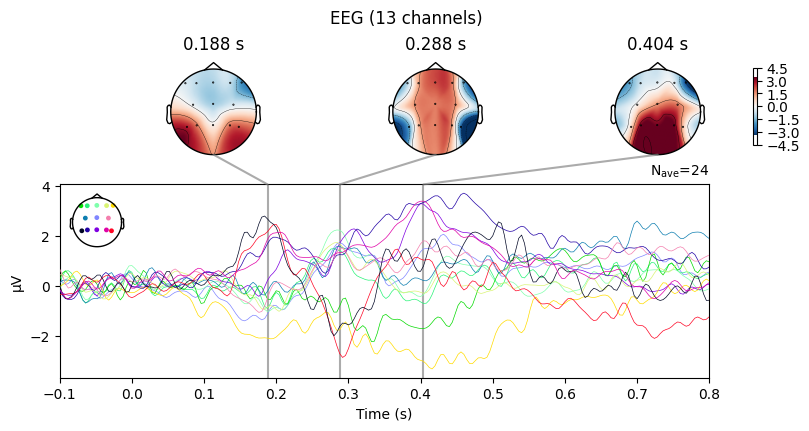

No projector specified for this dataset. Please consider the method self.add_proj.


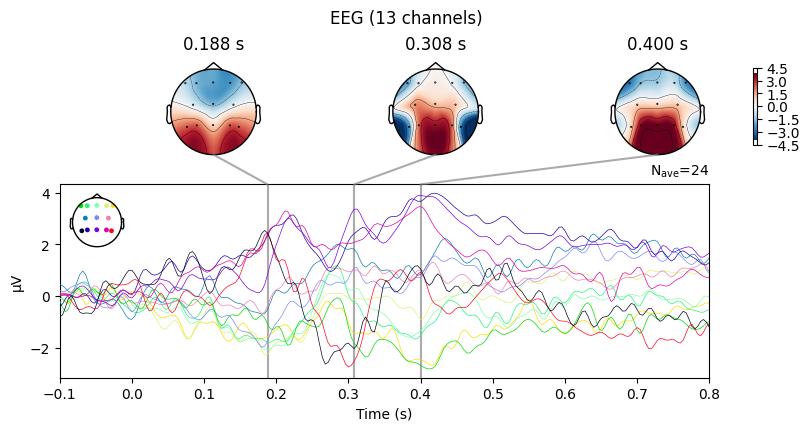

In [64]:
avg_cong.plot_joint();
avg_incong.plot_joint();

### Plot topomap

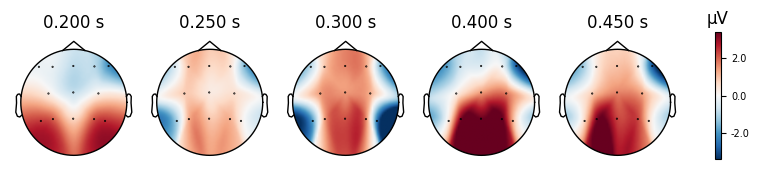

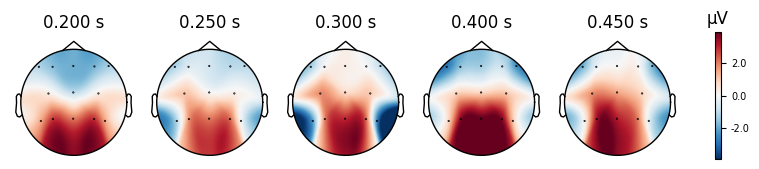

In [219]:
times = [0.2, 0.25, 0.3, 0.4, 0.45]  # Tiempos clave para topomap
avg_cong.plot_topomap(
    times=times,  # tiempos clave (en segundos)
    ch_type='eeg',                 # tipo de canal
    time_unit='s',                 # muestra tiempos en segundos
    outlines='head',               # contorno de cabeza
    contours=0,                    # no dibujar contornos adicionales
    sensors=True,                  # muestra posiciones de electrodos
    cmap='RdBu_r',                 # colormap rojo-azul (convención EEG)
);
avg_incong.plot_topomap(
    times=times,  # tiempos clave (en segundos)
    ch_type='eeg',                 # tipo de canal
    time_unit='s',                 # muestra tiempos en segundos
    outlines='head',               # contorno de cabeza
    contours=0,                    # no dibujar contornos adicionales
    sensors=True,                  # muestra posiciones de electrodos
    cmap='RdBu_r',                 # colormap rojo-azul (convención EEG)
);



No projector specified for this dataset. Please consider the method self.add_proj.


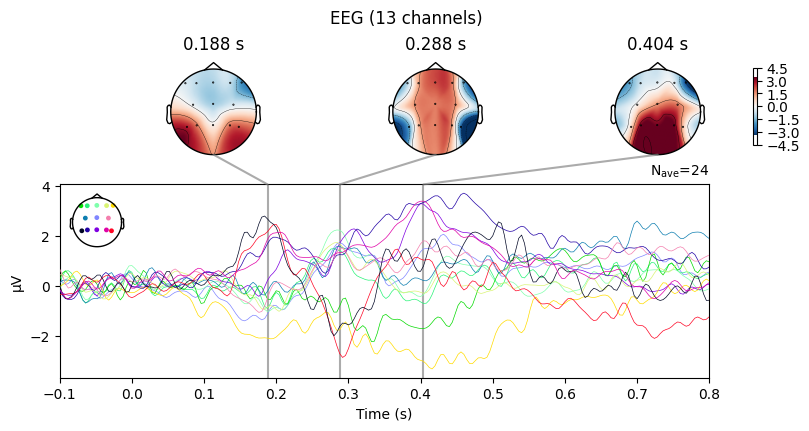

In [204]:
avg_cong.plot_joint();

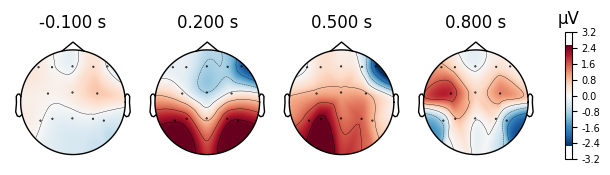

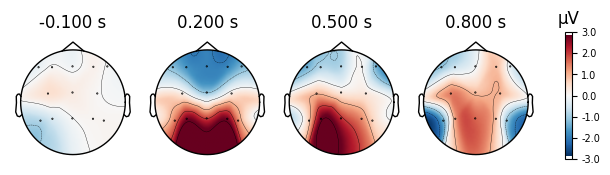

In [214]:
avg_cong.plot_topomap();
avg_incong.plot_topomap();

## Compare evokeds and plot joint

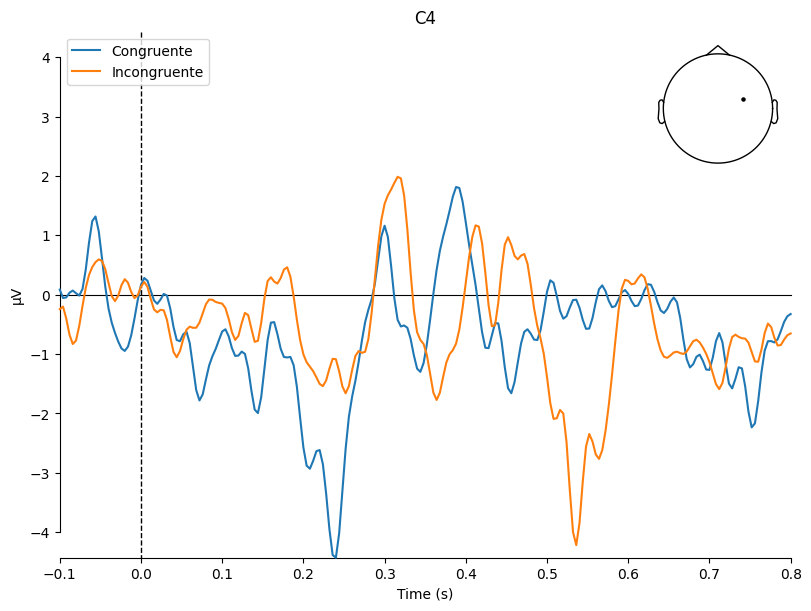

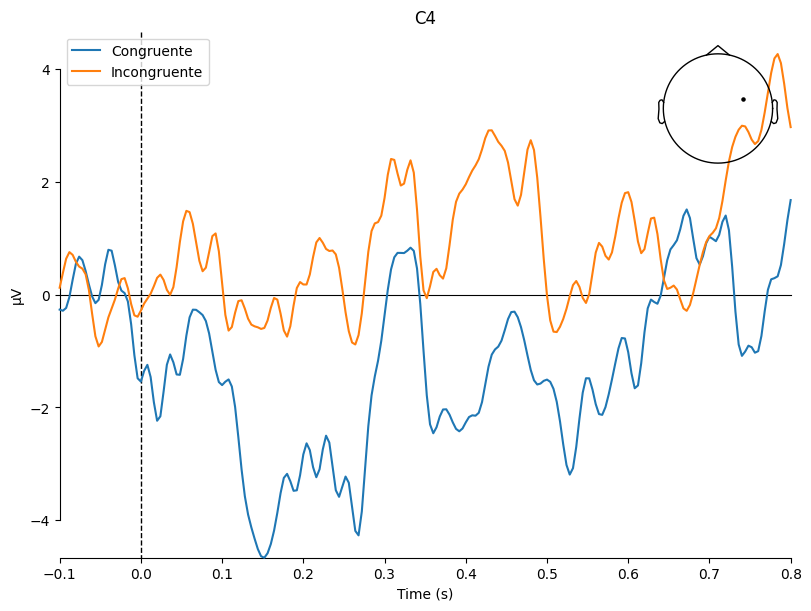

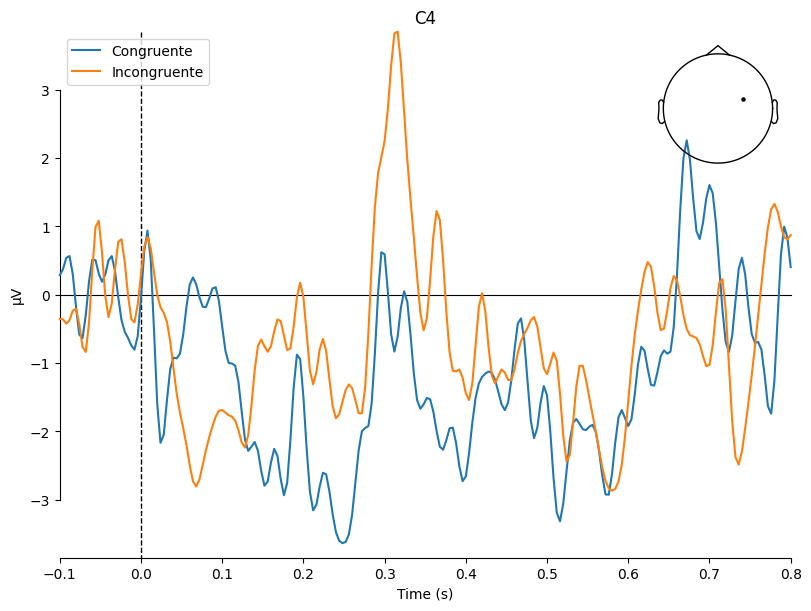

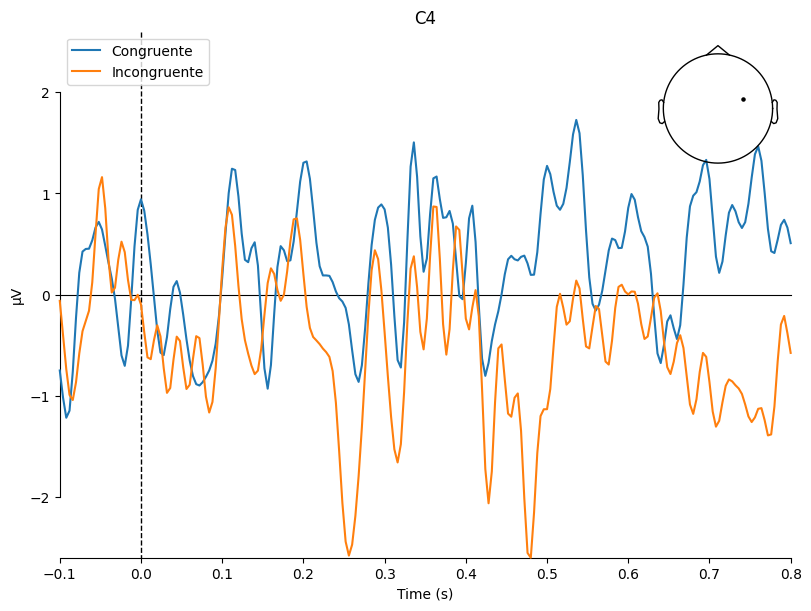

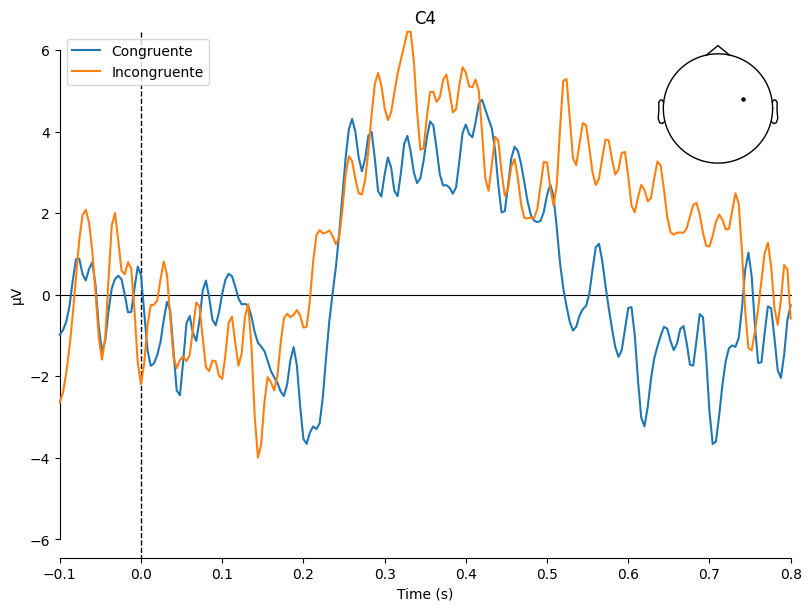

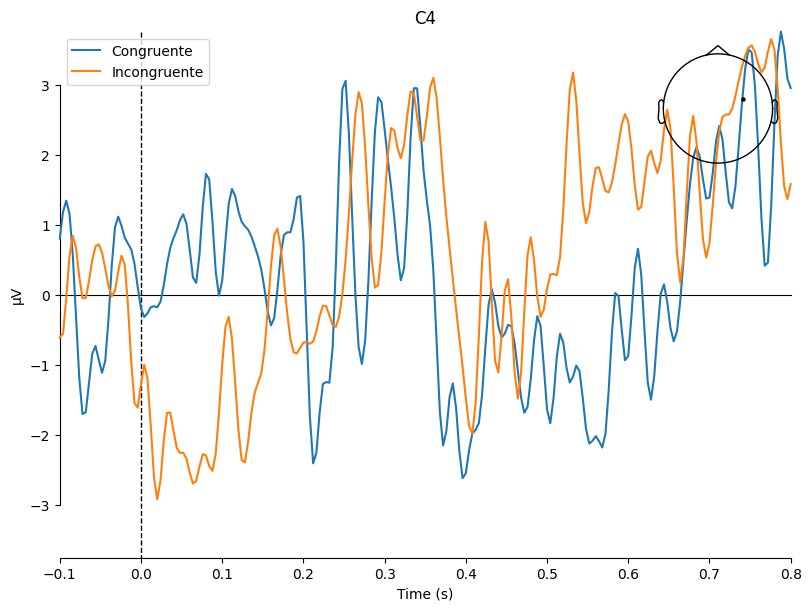

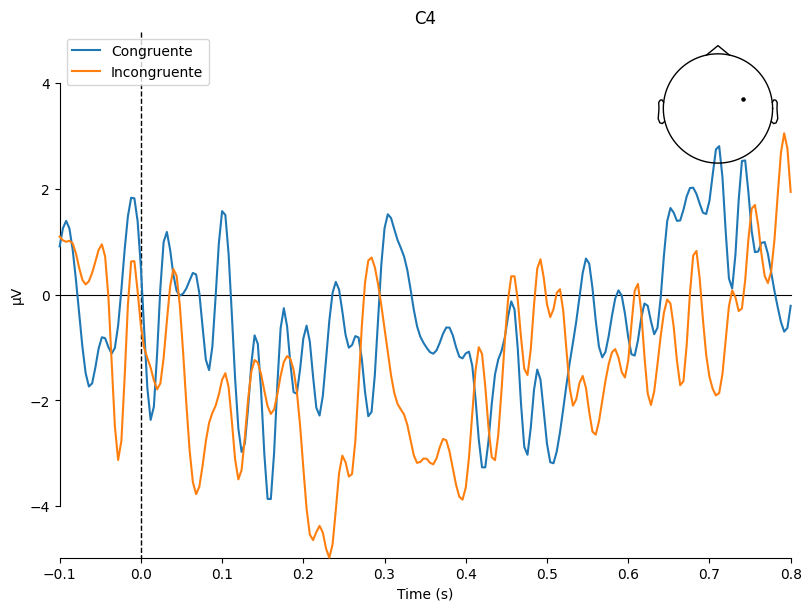

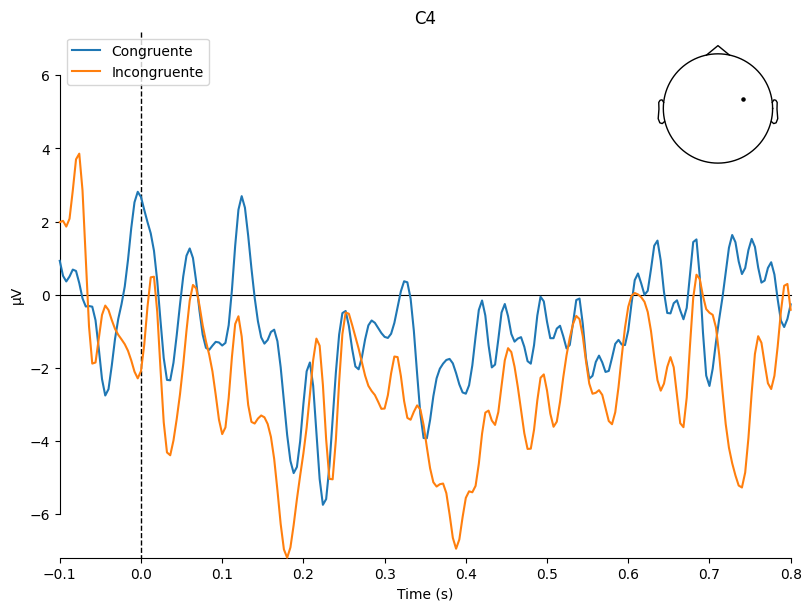

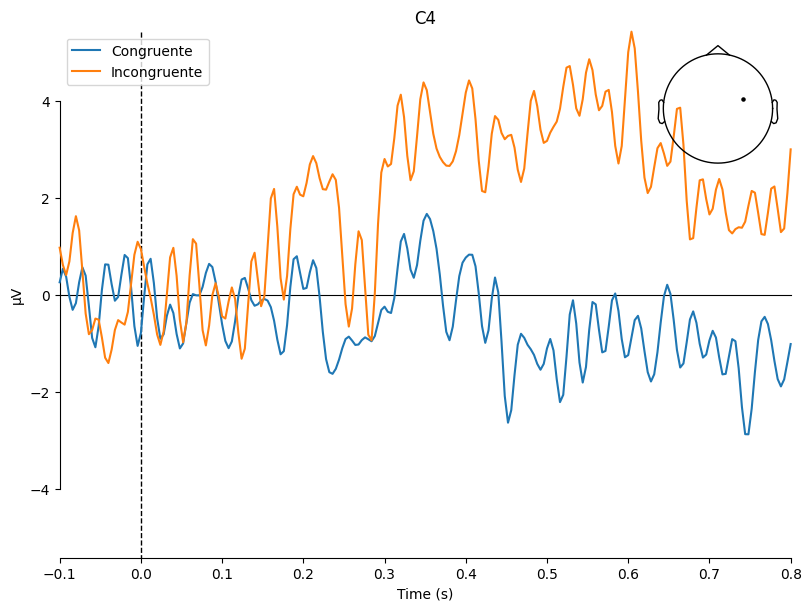

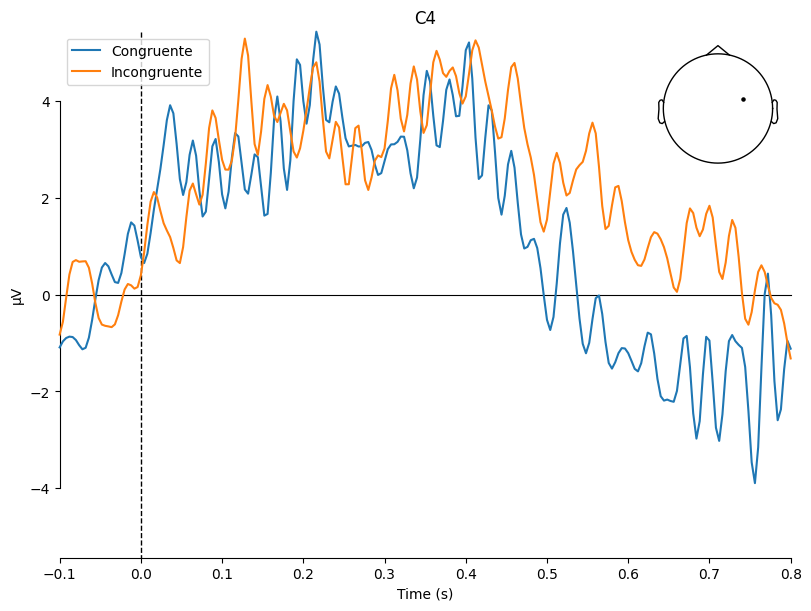

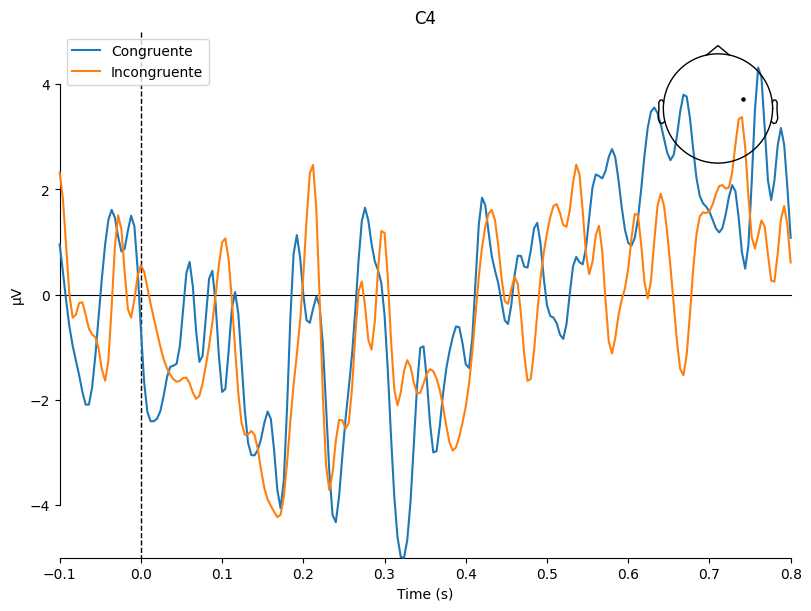

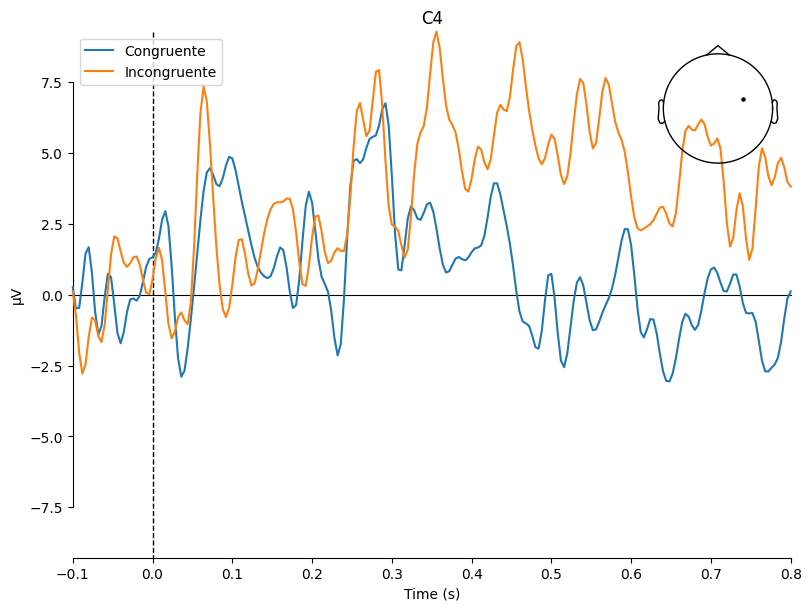

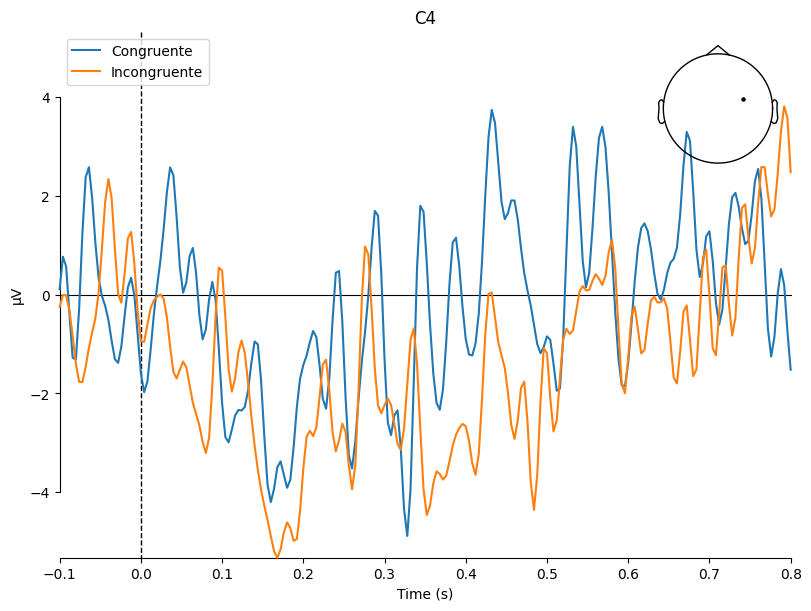

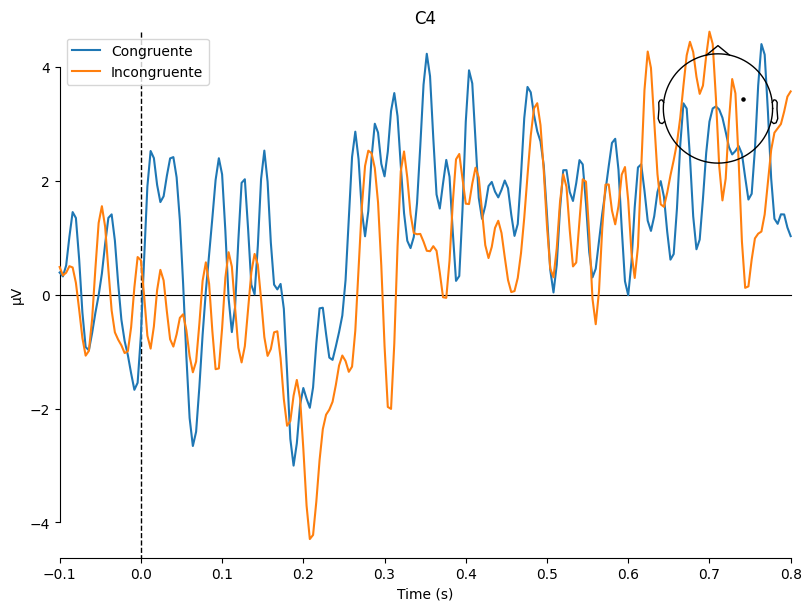

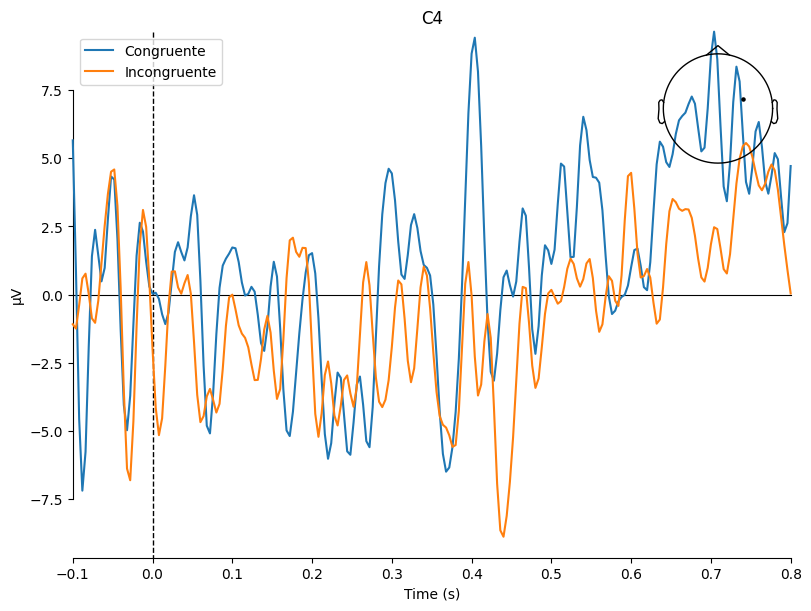

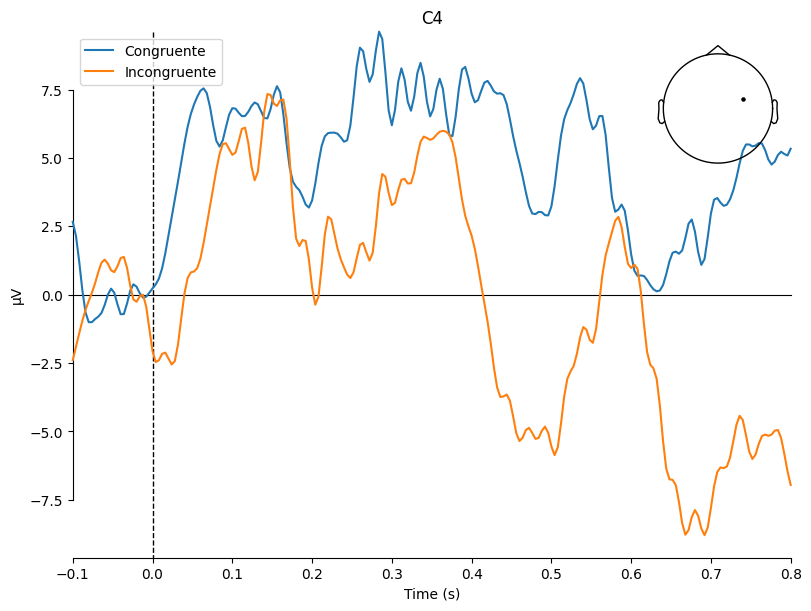

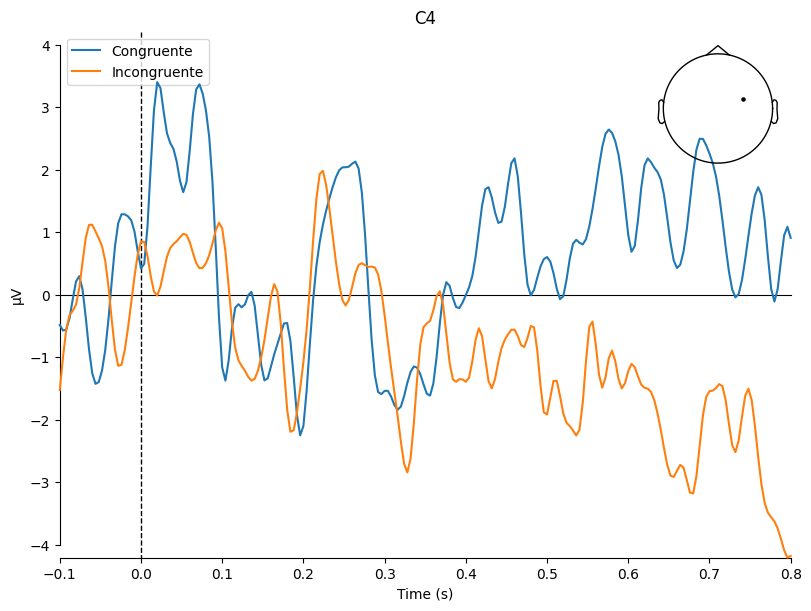

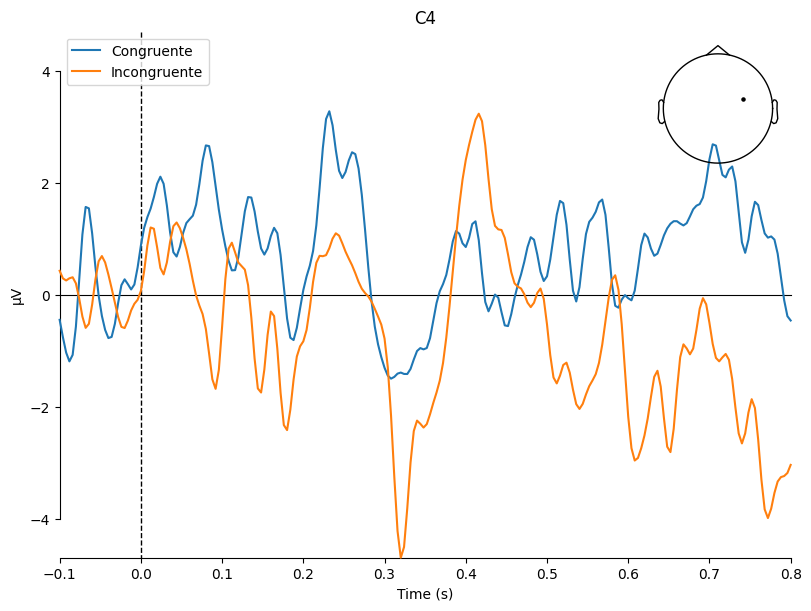

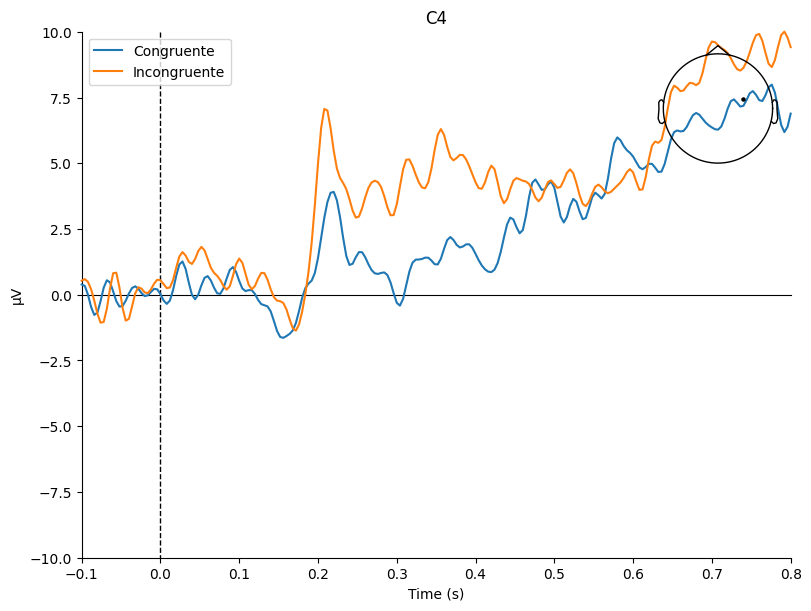

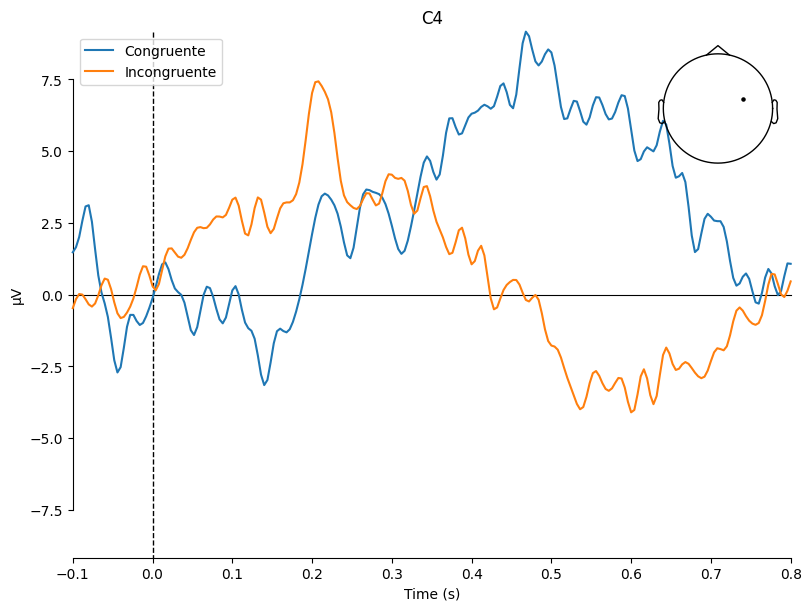

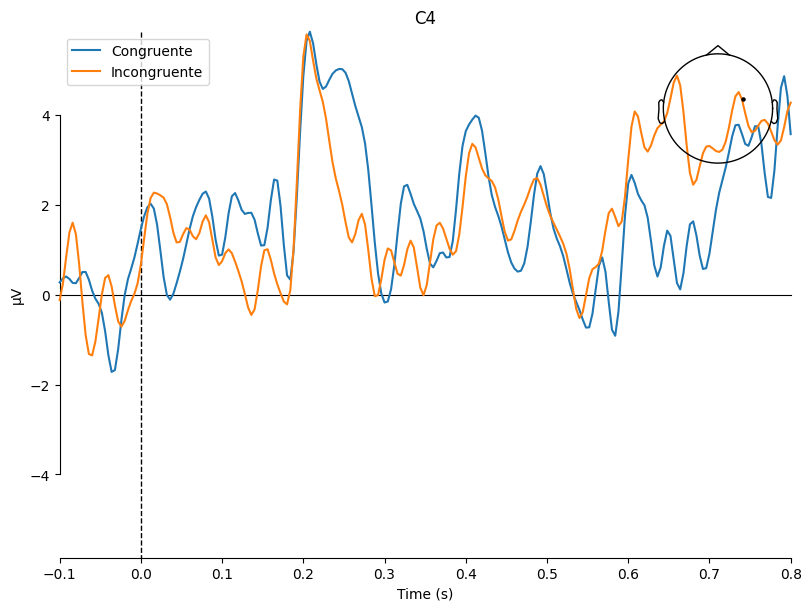

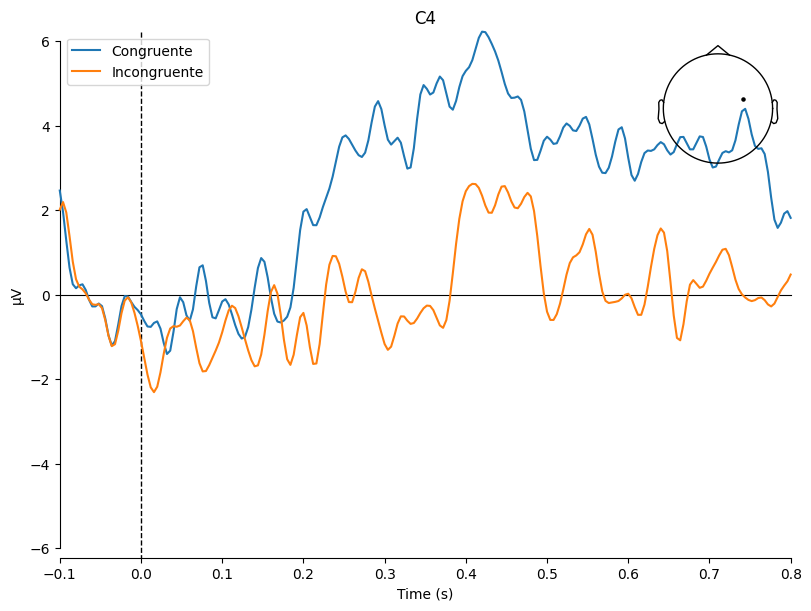

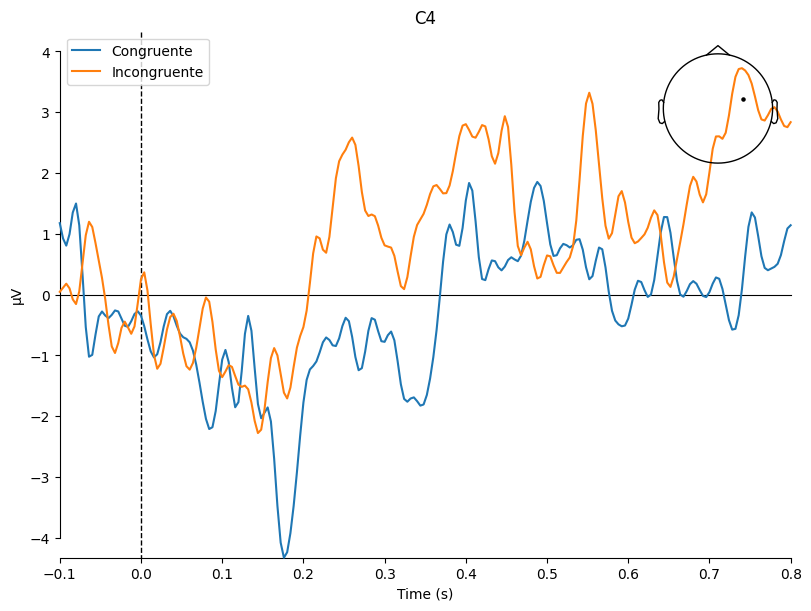

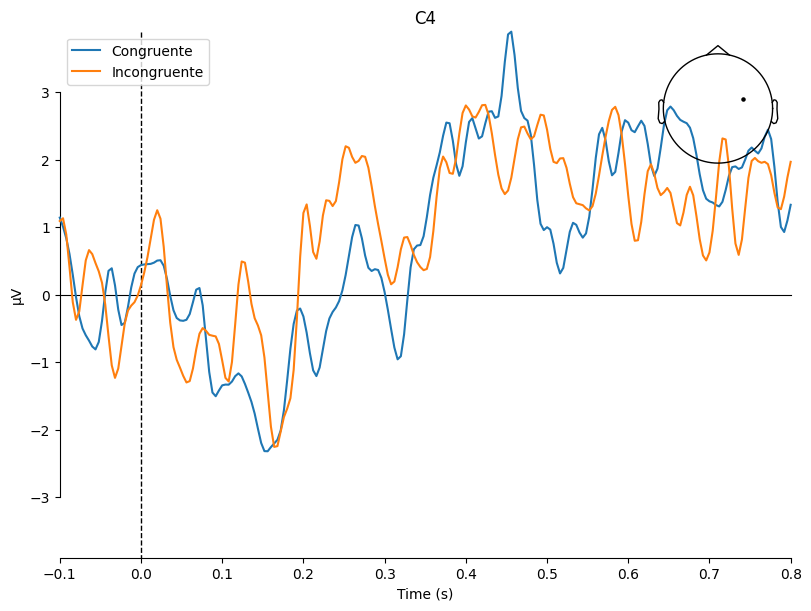

In [118]:
all_evks = []
for epochs in all_epochs:
    epochs.apply_baseline(baseline=(-0.1, 0), verbose=False)  # Eliminar desplazamiento antes del estímulo
    evoked_cong = epochs['WC'].average()
    evoked_incong = epochs['WI'].average()
    mne.viz.plot_compare_evokeds({'Congruente':evoked_cong, 'Incongruente': evoked_incong}, picks='C4');
    #evoked_cong.plot_joint()  # Especifica los picos de interés;
    #evoked_incong.plot_joint();  # usa los picos automáticamente
    

In [ ]:
epochs_wc_concat = mne.concatenate_epochs(all_epochs_wc)
epochs_wi_concat = mne.concatenate_epochs(all_epochs_wi)

# Guardar las épocas concatenadas y los nombres de archivo
with open("epochs_wc_concat.pkl", "wb") as f:
    pickle.dump(epochs_wc_concat, f)
with open("epochs_wi_concat.pkl", "wb") as f:
    pickle.dump(epochs_wi_concat, f)
with open("files_name.pkl", "wb") as f:
    pickle.dump(files_name, f)

print("Épocas concatenadas y nombres de archivo guardados.")